In [1]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta
from sgp4.api import Satrec, WGS72, jday
from mpl_toolkits.mplot3d import Axes3D

In [2]:
USERNAME = "EMAIL"
PASSWORD = "PASSWORD"

LOGIN_URL = "https://www.space-track.org/ajaxauth/login"
QUERY_URL = (
    "https://www.space-track.org/basicspacedata/query/"
    "class/gp/EPOCH/%3Enow-30/MEAN_MOTION/%3E11.25/"
    "ECCENTRICITY/%3C0.25/OBJECT_TYPE/payload/"
    "orderby/NORAD_CAT_ID,EPOCH/format/3le"
)

In [3]:
# Earth radius in kilometers
EARTH_RADIUS = 6371

# Functions

### Data retrieval and parsing

In [4]:
def fetch_tle_text(username, password, login_url=LOGIN_URL, query_url=QUERY_URL):
    """
    Logs into Space-Track and retrieves TLE data (3-Line Element format).
    Returns the raw TLE text.
    """
    with requests.Session() as session:
        # Log in
        login_data = {"identity": username, "password": password}
        login_resp = session.post(login_url, data=login_data)
        login_resp.raise_for_status()
        
        # Perform the query
        resp = session.get(query_url)
        resp.raise_for_status()
        
        return resp.text


def parse_tle_to_dataframe(tle_text):
    """
    Parses TLE data in 3-line format (0/1/2) into a pandas DataFrame
    with columns ["Name", "Line1", "Line2"].
    """
    lines = [line.strip() for line in tle_text.strip().splitlines() if line.strip()]
    satellites = []

    if len(lines) % 3 != 0:
        print("Warning: The number of lines is not a multiple of 3. Some TLE entries may be incomplete.")

    for i in range(0, len(lines) - 2, 3):
        name_line = lines[i]
        line1 = lines[i + 1]
        line2 = lines[i + 2]

        if not name_line.startswith("0"):
            print(f"Unexpected format in name line: '{name_line}'. Skipping this entry.")
            continue
        if not line1.startswith("1"):
            print(f"Unexpected format in Line 1: '{line1}'. Skipping this entry.")
            continue
        if not line2.startswith("2"):
            print(f"Unexpected format in Line 2: '{line2}'. Skipping this entry.")
            continue

        name = name_line[1:].strip()  # Remove leading "0"
        satellites.append({"Name": name, "Line1": line1, "Line2": line2})

    return pd.DataFrame(satellites, columns=["Name", "Line1", "Line2"])

### Extract launch year and epoch

In [5]:
def extract_launch_year(line1):
    """
    Extracts the (4-digit) launch year from a TLE Line 1.
    """
    try:
        parts = line1.split()
        int_designator = parts[2]
        yy = int(int_designator[:2])

        # TLE convention: >= 57 => 19xx, else 20xx
        if yy >= 57:
            return 1900 + yy
        else:
            return 2000 + yy
    except (IndexError, ValueError) as e:
        print(f"Error extracting launch year from Line1: '{line1}'. Error: {e}")
        return None


def extract_tle_epoch(line1):
    """
    Extracts a Python datetime from TLE Line 1's epoch field.
    """
    try:
        match = re.search(r'(\d{2})(\d{3}\.\d+)', line1)
        if not match:
            return None
        
        year = int(match.group(1))
        day_of_year = float(match.group(2))

        # TLE year pivot
        if year >= 57:
            year += 1900
        else:
            year += 2000

        # day_of_year may have a fractional part => convert to seconds
        base_date = datetime(year, 1, 1)
        epoch_date = base_date + timedelta(
            days=int(day_of_year) - 1,
            seconds=(day_of_year % 1) * 86400
        )
        return epoch_date
    except Exception as e:
        print(f"Error extracting epoch: {e}")
        return None

### SGP4 Propogation

In [6]:
def get_satellite_position(line1, line2, when):
    """
    Returns the satellite (x, y, z) in km in the ECI frame at a given `when`.
    """
    try:
        sat = Satrec.twoline2rv(line1, line2, WGS72)
        jd, fr = jday(
            when.year, when.month, when.day,
            when.hour, when.minute, when.second + when.microsecond * 1e-6
        )
        error_code, r, v = sat.sgp4(jd, fr)
        if error_code != 0:
            print(f"SGP4 Error {error_code} for Satellite: {sat.satnum}")
            return None
        return r
    except Exception as e:
        print(f"Exception during propagation: {e}")
        return None


def get_satellite_positions(line1, line2, start_datetime, duration_minutes=90, step_seconds=30):
    """
    Propagate satellite positions over a duration, returning (x, y, z) arrays.
    """
    sat = Satrec.twoline2rv(line1, line2, WGS72)
    positions_x, positions_y, positions_z = [], [], []

    total_steps = int((duration_minutes * 60) / step_seconds)
    for step in range(total_steps + 1):
        current_time = start_datetime + timedelta(seconds=step * step_seconds)
        jd, fr = jday(
            current_time.year, current_time.month, current_time.day,
            current_time.hour, current_time.minute, current_time.second + current_time.microsecond * 1e-6
        )
        e, r, v = sat.sgp4(jd, fr)
        if e == 0:
            positions_x.append(r[0])
            positions_y.append(r[1])
            positions_z.append(r[2])
        else:
            positions_x.append(np.nan)
            positions_y.append(np.nan)
            positions_z.append(np.nan)

    return positions_x, positions_y, positions_z

### Plotting helpers

In [7]:
def plot_earth(ax, radius=EARTH_RADIUS, color='blue', alpha=1.0):
    """
    Plots a wireframe sphere representing the Earth on a 3D axis.
    """
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x_earth = radius * np.cos(u) * np.sin(v)
    y_earth = radius * np.sin(u) * np.sin(v)
    z_earth = radius * np.cos(v)
    ax.plot_surface(x_earth, y_earth, z_earth, color=color, alpha=alpha)
    

def draw_radial_line(ax, start_radius=EARTH_RADIUS, extension=2000, color='red'):
    """
    Draws a line from Earth's surface out to (surface + extension).
    """
    line_len = start_radius + extension
    x_line = [start_radius, line_len]
    y_line = [0, 0]
    z_line = [0, 0]
    ax.plot(x_line, y_line, z_line, color=color, linewidth=2)
    ax.text(
        line_len + 100, 0, 0,
        f"{extension} km", color=color,
        fontsize=10, horizontalalignment='left', verticalalignment='center'
    )


def make_axes_equal(ax, limit):
    """
    Sets 3D plot limits to keep the aspect ratio equal.
    Removes ticks and labels for a cleaner look.
    """
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.set_zlim(-limit, limit)

    # Hide ticks and labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    ax._axis3don = False

### 3D plotting helpers

In [8]:
def plot_leo_satellite_distribution(tle_df, snapshot_datetime):
    """
    Plots the positions of satellites in 3D at a single snapshot in time.
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    fig.suptitle("LEO Satellite Distribution", fontsize=16, x=0.525, y=0.75)
    
    xs, ys, zs = [], [], []
    launch_years = []

    # Collect satellite positions
    for _, row in tle_df.iterrows():
        r = get_satellite_position(row['Line1'], row['Line2'], snapshot_datetime)
        if r is not None:
            xs.append(r[0])
            ys.append(r[1])
            zs.append(r[2])
            launch_years.append(row['Launch Year'])

    # Scatter-plot satellites
    sc = ax.scatter(xs, ys, zs, s=1, c=launch_years, cmap='inferno', label='Satellites')
    
    # Plot Earth
    plot_earth(ax, radius=EARTH_RADIUS, color='blue', alpha=1.0)
    
    # Draw radial line from Earth out 2000 km
    draw_radial_line(ax, start_radius=EARTH_RADIUS, extension=2000)
    
    # Colorbar for launch years
    cbar = fig.colorbar(sc, ax=ax, shrink=0.6, pad=-0.025)
    cbar.set_label('Launch Year', fontsize=12)

    # Make aspect ratio equal
    if xs and ys and zs:
        max_val = max(
            np.max(np.abs(xs)),
            np.max(np.abs(ys)),
            np.max(np.abs(zs)),
            EARTH_RADIUS
        )
    else:
        max_val = EARTH_RADIUS

    make_axes_equal(ax, limit=max_val)
    ax.legend(loc='lower left', bbox_to_anchor=(0.1, 0.1), fontsize=12)

    plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.2)
    plt.show()


def plot_leo_satellite_orbits(tle_df, snapshot_datetime, duration_minutes=24*60, step_seconds=30, orbit_subset=5):
    """
    Plots a subset of orbits (tracks) plus the snapshot positions for all satellites.
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    fig.suptitle("LEO Satellite Orbits", fontsize=16, x=0.525, y=0.75)

    # Plot current snapshot positions for all valid satellites
    xs_current, ys_current, zs_current = [], [], []
    for _, row in tle_df.iterrows():
        r = get_satellite_position(row['Line1'], row['Line2'], snapshot_datetime)
        if r is not None:
            xs_current.append(r[0])
            ys_current.append(r[1])
            zs_current.append(r[2])

    ax.scatter(xs_current, ys_current, zs_current, s=1, color='black', label='Current Positions')

    # Plot orbits for a subset
    subset = tle_df.head(orbit_subset)
    for idx, row in subset.iterrows():
        track_x, track_y, track_z = get_satellite_positions(
            row['Line1'],
            row['Line2'],
            snapshot_datetime,
            duration_minutes=duration_minutes,
            step_seconds=step_seconds
        )
        ax.plot(
            track_x, track_y, track_z,
            linewidth=1,
            label=f"Orbit {idx} ({row['Launch Year']})"
        )

    # Plot Earth (wireframe)
    plot_earth(ax, radius=EARTH_RADIUS, color='blue', alpha=0.1)

    # Draw radial line from Earth out 2000 km
    draw_radial_line(ax, start_radius=EARTH_RADIUS, extension=2000)

    # Make aspect ratio equal
    if xs_current and ys_current and zs_current:
        max_val = max(
            np.max(np.abs(xs_current)),
            np.max(np.abs(ys_current)),
            np.max(np.abs(zs_current)),
            EARTH_RADIUS
        )
    else:
        max_val = EARTH_RADIUS

    make_axes_equal(ax, limit=max_val)
    ax.legend(loc='lower left', bbox_to_anchor=(0.1, 0.1), fontsize=12)

    plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.2)
    plt.show()

### Main function

In [11]:
def pull_tle_data():
    """
    1) Fetch raw TLE data from Space-Track
    2) Parse into DataFrame
    3) Add Launch Year & TLE Epoch
    4) Filter for recency (<= 30 days)
    5) Return the resulting DataFrame (NO plots)
    """
    # 1) Fetch
    tle_text = fetch_tle_text(USERNAME, PASSWORD)

    # 2) Parse
    df = parse_tle_to_dataframe(tle_text)

    # 3) Enrich
    df['Launch Year'] = df['Line1'].apply(extract_launch_year)
    df['Epoch'] = df['Line1'].apply(extract_tle_epoch)
    df['Epoch_Diff_Days'] = df['Epoch'].apply(
        lambda x: abs((datetime.utcnow() - x).days) if x else None
    )

    # 4) Filter
    filtered = df[(df['Epoch_Diff_Days'] <= 30) & df['Epoch_Diff_Days'].notnull()]
    print(f"Number of TLEs after filtering: {len(filtered)}")

    return filtered

filtered_tle_df = pull_tle_data()

Number of TLEs after filtering: 11405


# Plotting

### Histogram of launch count by year

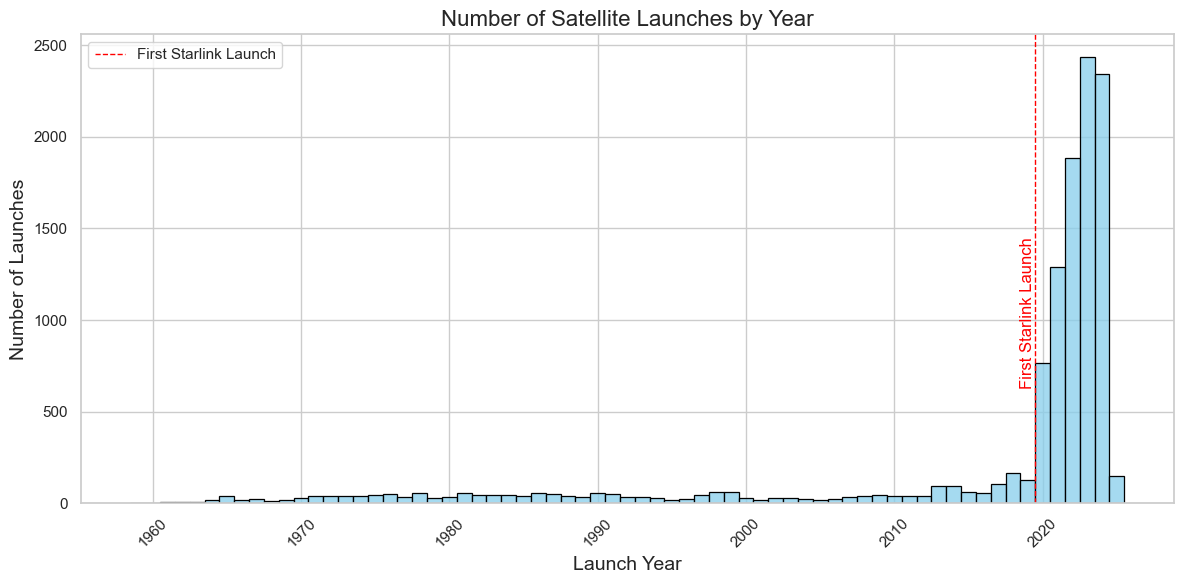

In [12]:
# You can set these parameters inline:
BINSIZE = 1  # Just an example parameter
STARLINK_LINE = 2019.45

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# If you want to control the bin range more precisely:
min_year = filtered_tle_df['Launch Year'].min()
max_year = filtered_tle_df['Launch Year'].max()
bins = range(min_year, max_year + 2, BINSIZE)

sns.histplot(
    data=filtered_tle_df,
    x='Launch Year',
    bins=bins,
    discrete=True,
    kde=False,
    color='skyblue',
    edgecolor='black'
)

plt.title('Number of Satellite Launches by Year', fontsize=16)
plt.xlabel('Launch Year', fontsize=14)
plt.ylabel('Number of Launches', fontsize=14)

# Annotate
plt.axvline(x=STARLINK_LINE, color='red', linestyle='--', label='First Starlink Launch', linewidth=1)
plt.annotate(
    'First Starlink Launch',
    xy=(STARLINK_LINE, plt.ylim()[1] * 0.25),
    xytext=(STARLINK_LINE - 1, plt.ylim()[1] * 0.25),
    color='red',
    fontsize=12,
    rotation=90,
)

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Positions and tracks in 3D

In [ ]:
# Set the time for grabbing the positions
SNAPSHOT_TIME = datetime(2025, 1, 25, 0, 0, 0)

# Initialize arrays
xs, ys, zs = [], [], []
launch_years = []

# Loop through TLE data and grab x,y,z positions and launch year
for _, row in filtered_tle_df.iterrows():
    pos = get_satellite_position(row['Line1'], row['Line2'], SNAPSHOT_TIME)
    if pos is not None:
        xs.append(pos[0])
        ys.append(pos[1])
        zs.append(pos[2])
        launch_years.append(row['Launch Year'])

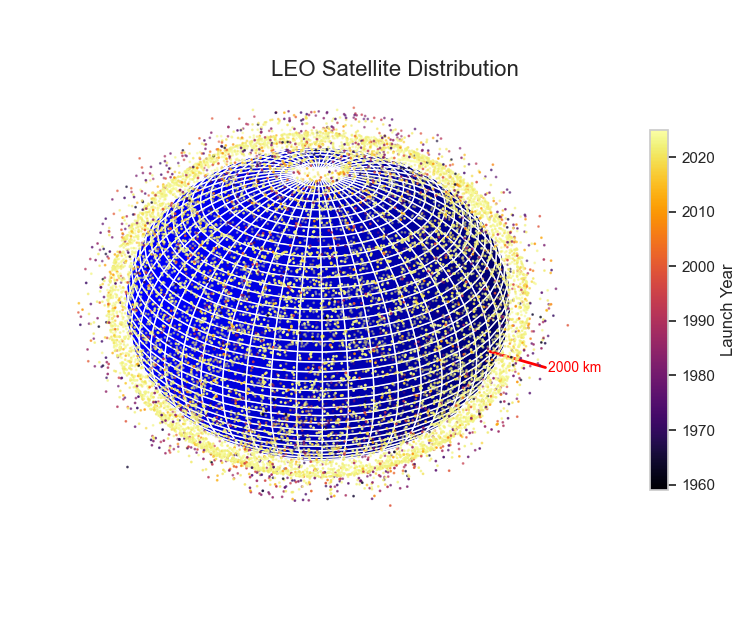

In [26]:
# Plot 3D satellite positions
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle("LEO Satellite Distribution", fontsize=16, x=0.525, y=0.75)

# Scatter-plot for positions, color-coded by launch year
sc = ax.scatter(xs, ys, zs, s=1, c=launch_years, cmap='inferno')

# Wireframe for Earth surface
u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
x_earth = EARTH_RADIUS * np.cos(u) * np.sin(v)
y_earth = EARTH_RADIUS * np.sin(u) * np.sin(v)
z_earth = EARTH_RADIUS * np.cos(v)
ax.plot_surface(x_earth, y_earth, z_earth, color='blue', alpha=1.0)

# Radial line for scale
extension = 2000
line_len = EARTH_RADIUS + extension
ax.plot([EARTH_RADIUS, line_len], [0, 0], [0, 0], color='red', linewidth=2)
ax.text(
    line_len + 100, 0, 0,
    f"{extension} km",
    color='red',
    fontsize=10,
    horizontalalignment='left',
    verticalalignment='center'
)

max_val = EARTH_RADIUS
ax.set_xlim(-max_val, max_val)
ax.set_ylim(-max_val, max_val)
ax.set_zlim(-max_val, max_val)

# Hide ticks
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax._axis3don = False

# Colorbar
cbar = fig.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label('Launch Year', fontsize=12)

plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.2)
plt.show()

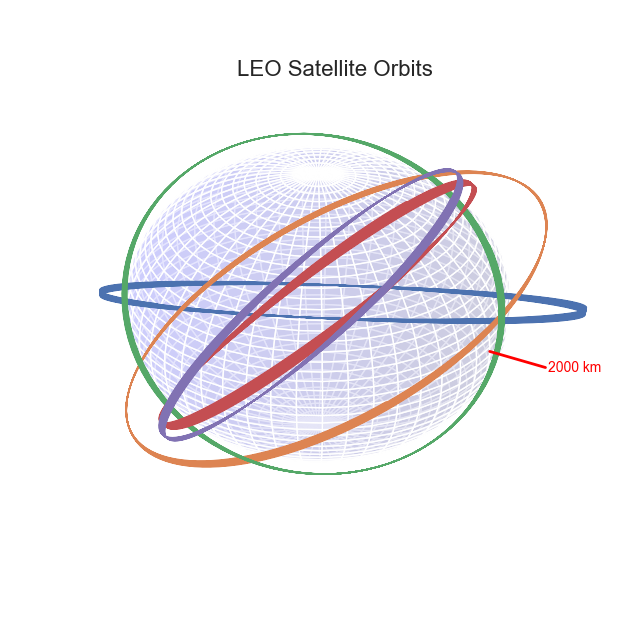

In [18]:
DURATION_MINUTES = 1440  # 24 hours
STEP_SECONDS = 60
ORBIT_SUBSET = 5  # number of orbits to plot

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle("LEO Satellite Orbits", fontsize=16, x=0.525, y=0.75)

# Plot orbits for a subset
subset_df = filtered_tle_df.head(ORBIT_SUBSET)
for idx, row in subset_df.iterrows():
    x_track, y_track, z_track = get_satellite_positions(
        row['Line1'], row['Line2'],
        SNAPSHOT_TIME,
        duration_minutes=DURATION_MINUTES,
        step_seconds=STEP_SECONDS
    )
    ax.plot(
        x_track, y_track, z_track,
        linewidth=1,
        label=f"Orbit {idx} (Launch Year: {row['Launch Year']})"
    )

# Plot Earth
u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
x_earth = EARTH_RADIUS * np.cos(u) * np.sin(v)
y_earth = EARTH_RADIUS * np.sin(u) * np.sin(v)
z_earth = EARTH_RADIUS * np.cos(v)
ax.plot_surface(x_earth, y_earth, z_earth, color='blue', alpha=0.1)

# Radial line
extension = 2000
line_len = EARTH_RADIUS + extension
ax.plot([EARTH_RADIUS, line_len], [0, 0], [0, 0], color='red', linewidth=2)
ax.text(
    line_len + 100, 0, 0,
    f"{extension} km",
    color='red',
    fontsize=10,
    horizontalalignment='left',
    verticalalignment='center'
)

max_val = EARTH_RADIUS

ax.set_xlim(-max_val, max_val)
ax.set_ylim(-max_val, max_val)
ax.set_zlim(-max_val, max_val)

# Hide ticks
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax._axis3don = False

#ax.legend(loc='lower left', bbox_to_anchor=(0.1, 0.1), fontsize=12)
plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.2)
plt.show()